In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from diffusers import DDPMPipeline
import torchmetrics


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "google/ddpm-cifar10-32"
pipeline = DDPMPipeline.from_pretrained(model_id).to(device)
unet = pipeline.unet.eval()
scheduler = pipeline.scheduler


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/vscode/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /home/vscode/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [3]:
class ToyShapesDataset(Dataset):
    def __init__(self, n_samples=20, img_size=32):
        self.n = n_samples
        self.img_size = img_size

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        img = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
        mask = np.zeros((self.img_size, self.img_size), dtype=np.uint8)

        # Random square
        x, y = np.random.randint(0, self.img_size//2, 2)
        size = np.random.randint(8, 16)
        img[y:y+size, x:x+size] = [255, 0, 0]
        mask[y:y+size, x:x+size] = 1

        # Random circle
        cx, cy = np.random.randint(8, self.img_size-8, 2)
        r = np.random.randint(5, 10)
        for i in range(self.img_size):
            for j in range(self.img_size):
                if (i-cy)**2 + (j-cx)**2 < r**2:
                    img[i,j] = [0, 255, 0]
                    mask[i,j] = 2

        transform = T.Compose([
            T.ToTensor(),
            lambda x: 2*x - 1  # scale to [-1,1]
        ])

        return transform(Image.fromarray(img)), torch.from_numpy(mask).long()

train_ds = ToyShapesDataset(10)
test_ds = ToyShapesDataset(5)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1)


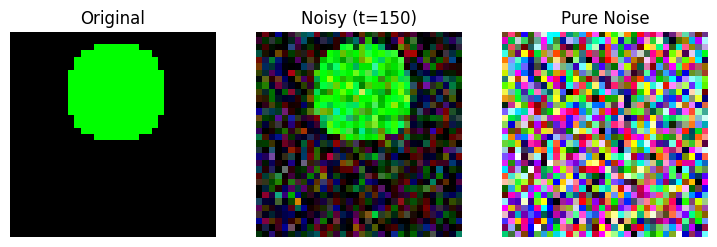

In [4]:
def add_noise(image, timestep, scheduler, device=device):
    noise = torch.randn_like(image).to(device)
    noisy = scheduler.add_noise(image, noise, timestep)
    return noisy, noise

def show_noisy_example(img, timestep):
    """
    img: torch.Tensor, shape (3,H,W), scaled to [-1,1]
    timestep: torch.tensor([t]) on device
    """
    img = img.unsqueeze(0).to(device)
    noisy, noise = add_noise(img, timestep, scheduler)

    fig, axs = plt.subplots(1,3, figsize=(9,3))
    
    axs[0].imshow(((img[0].cpu().permute(1,2,0)+1)/2).clamp(0,1))
    axs[0].set_title("Original")
    
    axs[1].imshow(((noisy[0].cpu().permute(1,2,0)+1)/2).clamp(0,1))
    axs[1].set_title(f"Noisy (t={timestep.item()})")
    
    axs[2].imshow(((noise[0].cpu().permute(1,2,0)+1)/2).clamp(0,1))
    axs[2].set_title("Pure Noise")
    
    for ax in axs: 
        ax.axis("off")
    plt.show()

# Example run
img, _ = train_ds[0]
show_noisy_example(img, torch.tensor([150], device=device))



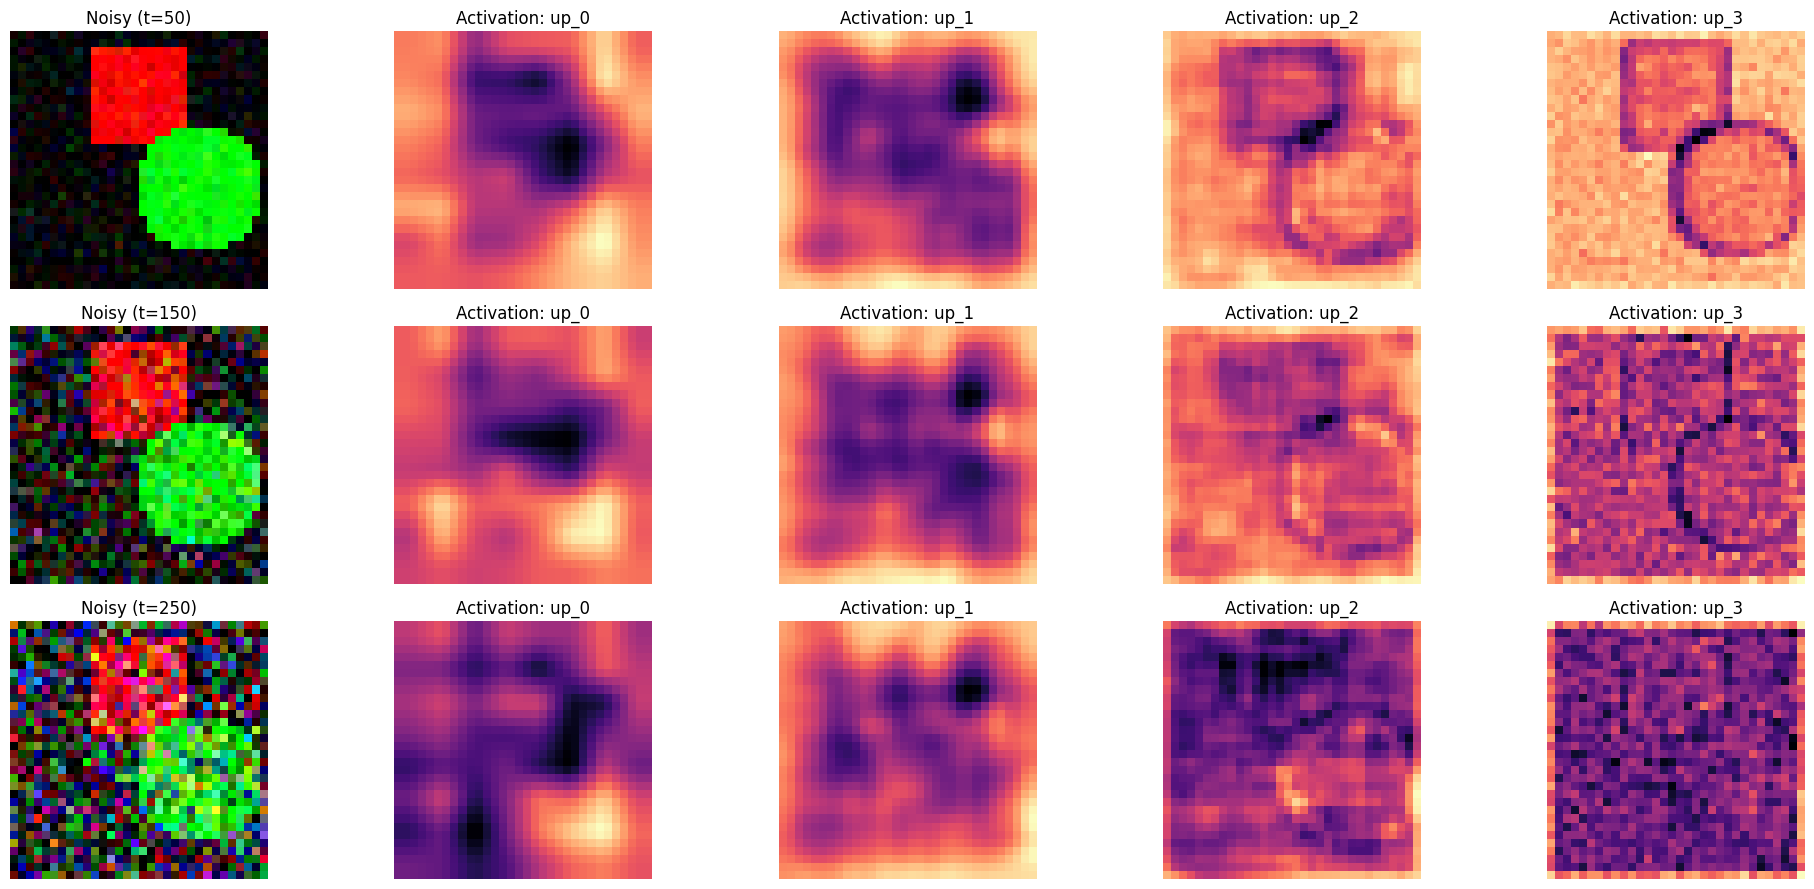

In [5]:
# ---- Register hooks on up_blocks ----
features = {}

def hook_fn(name):
    def fn(_, __, output):
        features[name] = output
    return fn

# Attach hooks to all up_blocks (decoder)
for i, block in enumerate(unet.up_blocks):
    block.register_forward_hook(hook_fn(f"up_{i}"))

# ---- Define which blocks to visualize ----
# (paper: {5,6,7,8,12} → HuggingFace approx. "up_1","up_2","up_3")
wanted_blocks = ["up_0", "up_1", "up_2", "up_3"]  
timesteps_to_try = [50, 150, 250]

# ---- Visualization function ----
def visualize_features_multi_t(img, timesteps):
    """
    Show noisy input + selected decoder activations for multiple timesteps.
    Each row = one timestep
    Col 0 = noisy input, Col 1..N = activations from wanted_blocks
    """
    img = img.unsqueeze(0).to(device)

    n_rows = len(timesteps)
    n_cols = 1 + len(wanted_blocks)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

    for row, t in enumerate(timesteps):
        t = torch.tensor([t], device=device)
        noisy, _ = add_noise(img, t, scheduler)
        features.clear()
        _ = unet(noisy, t)

        # Column 0: noisy input
        axs[row,0].imshow(((noisy[0].cpu().permute(1,2,0)+1)/2).clamp(0,1))
        axs[row,0].set_title(f"Noisy (t={t.item()})")
        axs[row,0].axis("off")

        # Columns 1..N: activations
        for col, blk in enumerate(wanted_blocks, start=1):
            if blk not in features:
                axs[row,col].set_title(f"{blk} (missing)")
                axs[row,col].axis("off")
                continue

            fmap = features[blk][0]  # (C,H,W)
            fmap = F.interpolate(fmap.unsqueeze(0), size=img.shape[-2:], mode="bilinear")[0]
            fmap_vis = fmap.mean(0).detach().cpu().numpy()
            axs[row,col].imshow(fmap_vis, cmap="magma")
            axs[row,col].set_title(f"Activation: {blk}")
            axs[row,col].axis("off")

    plt.tight_layout()
    plt.show()

# ---- Example run ----
img, _ = train_ds[0]
visualize_features_multi_t(img, timesteps_to_try)


In [6]:
def extract_features(img, timestep, target_size=(32,32)):
    xt, _ = add_noise(img, timestep, scheduler)
    features.clear()
    _ = unet(xt, timestep)
    upsampled = []
    for name, fmap in features.items():
        fmap = F.interpolate(fmap, size=target_size, mode="bilinear", align_corners=False)
        upsampled.append(fmap)
    return torch.cat(upsampled, dim=1)  # (B, D, H, W)



In [7]:
class PixelMLP(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.net(x)

def make_ensemble(in_dim, num_classes, n=3):
    return [PixelMLP(in_dim, num_classes).to(device) for _ in range(n)]


In [8]:
num_classes = 3
timesteps = torch.tensor([100], device=device)

# Extract one batch to infer input dim
img, mask = next(iter(train_loader))
feat = extract_features(img.to(device), timesteps)
in_dim = feat.shape[1]

ensemble = make_ensemble(in_dim, num_classes)
optims = [torch.optim.Adam(m.parameters(), lr=1e-3) for m in ensemble]
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        feats = extract_features(imgs, timesteps, target_size=imgs.shape[-2:])
        B,C,H,W = feats.shape

        # Detach features since diffusion model is frozen
        X = feats.permute(0,2,3,1).reshape(-1,C).detach()
        y = masks.view(-1)

        for model, optim in zip(ensemble, optims):
            optim.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optim.step()
    print(f"Epoch {epoch+1} done")


Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done
Epoch 10 done
Epoch 11 done
Epoch 12 done
Epoch 13 done
Epoch 14 done
Epoch 15 done
Epoch 16 done
Epoch 17 done
Epoch 18 done
Epoch 19 done
Epoch 20 done


In [9]:
miou = torchmetrics.JaccardIndex(task="multiclass", num_classes=num_classes).to(device)
acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)

def segment_image(img, models, timesteps):
    feats = extract_features(img, timesteps, target_size=img.shape[-2:])
    B,C,H,W = feats.shape
    X = feats.permute(0,2,3,1).reshape(-1,C)

    preds = []
    for model in models:
        out = model(X)
        preds.append(out.argmax(dim=1).view(H,W))
    preds = torch.stack(preds)
    return torch.mode(preds, dim=0)[0]

unet.eval()
for imgs, masks in test_loader:
    imgs, masks = imgs.to(device), masks.to(device)
    pred = segment_image(imgs, ensemble, timesteps)
    miou.update(pred.unsqueeze(0), masks)
    acc.update(pred.unsqueeze(0), masks)

print("Test mIoU:", miou.compute().item())
print("Test Pixel Accuracy:", acc.compute().item())


Test mIoU: 0.9994933605194092
Test Pixel Accuracy: 0.999804675579071


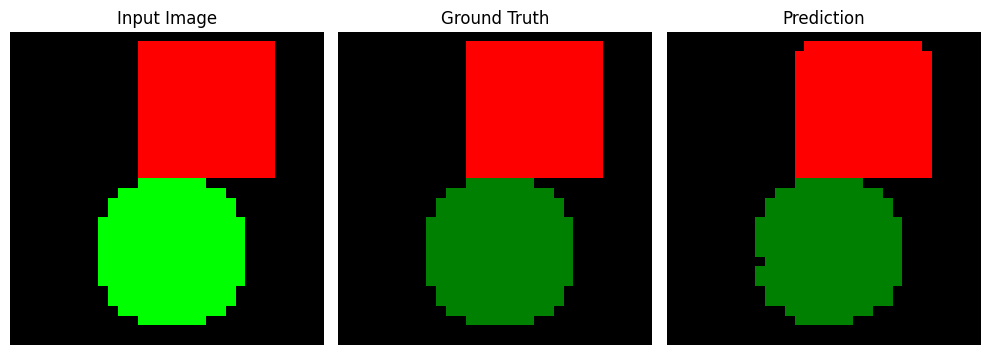

In [12]:
import matplotlib.colors as mcolors

# Define a colormap for segmentation masks
cmap = mcolors.ListedColormap(["black", "red", "green"])
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

def visualize_prediction(img, mask, models, t=150):
    """
    img: torch.Tensor (3,H,W), scaled [-1,1]
    mask: torch.Tensor (H,W)
    models: ensemble of classifiers
    t: timestep (int)
    """
    img_in = img.unsqueeze(0).to(device)
    timestep = torch.tensor([t], device=device)
    pred = segment_image(img_in, models, timesteps=timestep)

    fig, axs = plt.subplots(1,3, figsize=(10,4))

    axs[0].imshow(((img.cpu().permute(1,2,0)+1)/2).clamp(0,1))
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    axs[1].imshow(mask.cpu(), cmap=cmap, norm=norm)
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    axs[2].imshow(pred.cpu(), cmap=cmap, norm=norm)
    axs[2].set_title("Prediction")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

# ---- Example run ----
img, mask = test_ds[0]
visualize_prediction(img, mask, ensemble, t=150)
